#### Results Section Visualisation:
#### A Timeline to Estimate Future Species Abundance Levels if Long Term Trends Continue
- Encourages stakeholders to consider the consequences if long term trends persist.
- Contextualises long term trends - a 'due date' helps with understanding the 'severity' of decline.
- Highlights the worst performing species.

In [1]:
# Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

# Importing data
long_term_ra = pd.read_csv(project_root/'Data'/'UKBMS'/'species_timeline'/'species_timeline', index_col=0)

#### Computing the Average Rate of Decline Since 1993 (1st Survey Year)

In [3]:
# Subsetting 'long_term_ra' DataFrame to extract species in long term decline.
species_decline = long_term_ra.iloc[0:6, 0:3]

# Computing average rate of decline
species_decline['rate_of_decline'] = (
    (1-np.power( # 1-power is the percentage decline each year 
        1-abs(species_decline['percent_long_term'])/100, # the proportion remaining 
        1/30) # 30 years surveyed
    )*100
)

   species_code  percent_long_term          common_name
0           121         -90.381310  Essex/Small Skipper
1             2         -79.465138  Small Tortoiseshell
2            88         -47.916664        Large Skipper
3            99         -29.025198   Green-Veined White
4            84         -22.946072              Peacock
5           106         -14.169520          Common Blue
   species_code  percent_long_term          common_name  rate_of_decline
0           121         -90.381310  Essex/Small Skipper         7.508065
1             2         -79.465138  Small Tortoiseshell         5.140013
2            88         -47.916664        Large Skipper         2.150947
3            99         -29.025198   Green-Veined White         1.136312
4            84         -22.946072              Peacock         0.865118
5           106         -14.169520          Common Blue         0.508025


#### Computing the Number of Years for a Species to Become 'High Risk'
- A species becomes 'high risk' when relative abundance falls below 10% of baseline levels.

In [4]:
species_decline['years_to_high_risk'] = 0 # a new column is created with 'placer' value
for index, row in species_decline.iterrows():
    if row['percent_long_term']<-90: # percentage decrease from baseline levels
        species_decline.loc[index, 'years_to_high_risk'] = 0
    else:
        n=1 # will be used as power representing the number of years
        while (
            row['percent_long_term']+100) * # The percentage remaining from baseline
        # rate of decline (decimal form) to the power of 'n' (number of years)
        np.power(0.01*(100-row['rate_of_decline']), n) 
        >10: # The 'high risk' threshold
            n=n+1 # loop keeps adding years untill 'n' falls below threshold
            species_decline.loc[index, 'years_to_high_risk'] = n # total years
            
print(species_decline)

   species_code  percent_long_term          common_name  rate_of_decline  \
0           121         -90.381310  Essex/Small Skipper         7.508065   
1             2         -79.465138  Small Tortoiseshell         5.140013   
2            88         -47.916664        Large Skipper         2.150947   
3            99         -29.025198   Green-Veined White         1.136312   
4            84         -22.946072              Peacock         0.865118   
5           106         -14.169520          Common Blue         0.508025   

   years_to_high_risk  
0                   0  
1                  14  
2                  76  
3                 172  
4                 236  
5                 423  


#### Computing the Number of Years for Species to Become 'Moderate Risk'
- A species becomes 'moderate risk' when relative abundance falls below 25% of baseline levels. 

In [5]:
species_decline['years_to_mod_risk'] = 0 # a new column is created with 'placer' value
for index, row in species_decline.iterrows():
    if row['percent_long_term']<-75: # percentage decrease from baseline levels
        species_decline.loc[index, 'years_to_mod_risk'] = 0
    else:
        n=1 # will be used as power representing the number of years
        while (
            row['percent_long_term']+100) # The percentage remaining from baseline
         # rate of decline (decimal form) to the power of 'n' (number of years)
        * np.power(0.01*(100-row['rate_of_decline']), n)
        >25: # The 'moderate risk' threshold
            n=n+1 # loop keeps adding years untill 'n' falls below threshold
            species_decline.loc[index, 'years_to_mod_risk'] = n # total years

#### Determining the Year Species will Become High/Moderate Risk
The number of years (see cells above) is added to the latest survey year. 

In [6]:
species_decline['mod_risk_year'] = species_decline['years_to_mod_risk'] + 2023
species_decline['high_risk_year'] = species_decline['years_to_high_risk'] + 2023

#### Preparing Data for Visualisation
Identifying the most critical species and filtering the 'species_decline' dataframe

In [8]:
critical_list = [121,2,88] # codes belonging to the most critical species
most_critical = (
    species_decline[
    species_decline['species_code'].isin(critical_list)
    ]
    .reset_index(drop=True)
)

#### Creating the Visual

<Figure size 640x480 with 0 Axes>

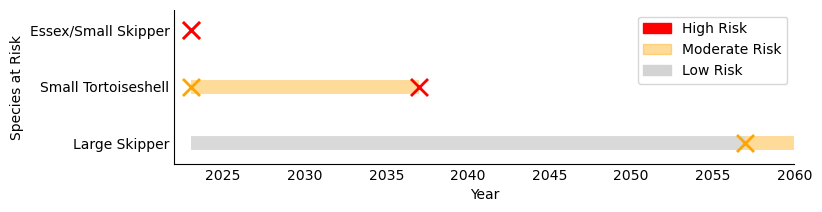

In [9]:
import matplotlib.patches as mpatches
plt.clf()

# formatting the plot
fig, ax = plt.subplots(figsize=(8,2))
sns.despine(right=True, left=False, top=True, bottom=False)
ax.tick_params(length=0)
ax.margins(y=0.18)

# A datapoint (representing the year a species becomes 'high risk') is added to the plot.
sns.scatterplot(data=most_critical,
            y='common_name',
           x='high_risk_year',
           color='red',
                marker='x',
                s=150,
                linewidth=2,
               zorder=4) # data points are placed over bars

# A datapoint (representing the year a species becomes 'mod risk') is added to the plot.
sns.scatterplot(data=most_critical,
            y='common_name',
           x='mod_risk_year',
               color='orange',
                marker='x',
                s=150,
                linewidth=2,
               zorder=3) # data points are placed over bars

# horizontal bars are drawn for time periods when a species is not considered at risk
plt.hlines(y=most_critical['common_name'],
          xmin=2023, # the start year on the x axis
          xmax=most_critical['mod_risk_year'], # the end year for the line
          color='black',
           alpha=0.15,
           linewidth=10,
          zorder=1) # the first layer. Data points go above.

# horizontal bars are drawn for time periods when a species is at 'moderate risk'
plt.hlines(y=most_critical['common_name'],
          xmin=most_critical['mod_risk_year'], # the start year on the x axis
          xmax=most_critical['high_risk_year'], # the end year for the line
          color='orange',
           linewidth=10,
           alpha=0.4,
          zorder=2) # goes behind data points

# Formatting plot x and y axis
plt.xticks(np.arange(2025,2065,5))
plt.xlim(2022,2060)
plt.xlabel('Year')
plt.ylabel('Species at Risk')

# Creating a custom legend
grey_patch = mpatches.Patch(color='lightgray', label='Low Risk')
orange_patch = mpatches.Patch(color='orange', label='Moderate Risk', alpha=0.4)
red_patch = mpatches.Patch(color='red', label='High Risk')
ax.legend(handles=[red_patch, orange_patch, grey_patch])

plt.savefig(project_root/'project_pics'/'species_timeline.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()